# Multiplex Ion Beam Imaging pre-processing tool - Python version 

Introduction: This Jupyter notebook is for MIBI data preprocessing and is the Python 3 version implementation of its original MATLAB version (https://github.com/lkeren/MIBIAnalysis) from Keren et al Cell 2018. 

Author: Yubin Xie from Dana Pe'er lab at Memorial Sloan Kettering Cancer Center and Daniel Li from Itsik Pe'er lab at Columbia University

Last update: 2019.11.03

## Load Libraires
Among the libraies, the utils is written by the authors and should be included in the same directory as the notebook

In [3]:
import PIL
from PIL import Image, ImageSequence
from PIL.TiffTags import TAGS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from skimage import exposure
import glob

The following package version is used in this example. However, the functions used here are very standard so that most version of these packages should work for this notebook.

scikit-learn==0.21.2
Pillow==6.0.0
pandas==0.24.2
numpy==1.16.0
matplotlib==3.1.0
scikit-image==0.16.2

## Define global parameter

### File path

* Important note: the corepath format is determined by the format of MIBI data you have

In [2]:
#### For MIBI data in a format that each channel is one file:
corePath = ['../data/demo_data/extracted/Point2/TIFs/*tif']  # path to data generated from the extraction process
#### For MIBI data downloaded from MIBI Tracker and all the channles are in one file. For example:
#corePath = ['../data/xxxx.tiff'] 

In [3]:
#### In the data folder, there should be a folder named info containing panel design and a run configuration file with format xml from the MIBI machine
massDS_path = '../data/demo_data/info/demopanel.csv'

### Parameter

In [4]:
bgChannel = ["Background"] # channel used for background signal. (Typically Au/Ta/Si/Background)
gausRad = 1 #radius of gaussian to use for signal smoothing (typically 1-3)
t_threshold = 0.2 # threshold for binary thresholding (0-1)
removeVal= 2 # value to remove from all channels in background-positive areas (increase for more aggressive removal)
evalChannel = ["dsDNA",'CD4'] # channel to plot for evaluating the background removal
capBgChannel = 50 # cap for plotting background channel
capEvalChannel = 5 # cap for plotting evaluation channel

load_data = 1;#% after the first time that you run the script you can change to 0 to save the loading time.
plotChannel = 'CD4';# % channel that you want to work on.
gausFlag = 1;# % flag of whether to do gaussian smoothing or not.
GausFlag = 1;
gausRad = 1; #% gauss radius for smoothing.
capImage = 5;# % value for capping the images when plotting. If colors are saturated, increase this number.

plot_channel=14

t = 100; #% Important: threshold used for aggregate removal. Components smaller than this size will be removed. Play with this number until you're happy with the results.

plot = False #True


## Load data

In [13]:
massDS = pd.read_csv(massDS_path)
print(massDS.head())

   Isotope Label  Start  Stop  BaselineStart  BaselineEnd  Batch  nnK  NoiseT
0       12     C   11.8  12.2           11.5         11.6      0   25     0.0
1       23    Na   22.8  23.2           22.5         22.6      0   25     0.0
2       28    Si   27.8  28.2           27.5         27.6      0   25     0.0
3       40    Ca   39.8  40.2           39.5         39.6      0   25     0.0
4       56    Fe   55.8  56.2           55.5         55.6      0   25     0.0


* Important note: the reading function for different MIBI data format is different. See below:

In [12]:
im_array = read_Angelo_image(massDS,folder=corePath[0])
#### For MIBI tracker image:
#im_array = read_MIBI_tracker_tiff(massDS,corePath[0])
print(im_array.shape)

(1024, 1024, 47)


## Remove background

Background subtraction: The background in MIBI image across all channels is highly similar to the blank channels and is usually located in the bare area on the slide. If not carefully handled, the noise can obscure the data. First, we define the blank channels (no antibody, usually mass 128-132) as the background channel. Then the background image was smoothed using a Gaussian kernel with radius as 3 pixels and masked as a binary image using thresholding method. All the signals in other channels are then subtracted by two counts and finally we recover negative counts as 0. Some channels have special background noise, which is usually from strong signal channels like gold. The same procedure should be additionally applied to these channels with the target channel as the background channel.

In [22]:
%%time
countsNoBg, countsAllSFiltCRSum = subtract_background(im_array,corePath, gausRad, bgChannel, massDS, capBgChannel, t_threshold, removeVal, evalChannel, plot)

CPU times: user 2.42 s, sys: 378 ms, total: 2.8 s
Wall time: 771 ms


## Remove noise

Noise removal: The signal in MIBI data can be very low intensity values, e.g., single count, and the signal can also be very sparse. This property makes the noise and true signal in the data very similar. Therefore, to address the noise removal problem, we aim to look at the density of signal instead of the intensity of signal. For each pixel in the image, we calculate the distance to the nearest 25 counts. By thresholding the distribution of the distance in a bimodal distribution method, the counts with low confidence are removed.

The noise removal step takes relatively longer time when compared to other steps due to k-nearest neighbor searching. By selecting the target channels/removing unnecessary channels can speed it up.

In [15]:
%%time
#noise_level(countsNoBg,massDS)
intND = get_intND(countsNoBg, massDS)




Working on 5
Working on 6
Working on 7
Working on 9
Working on 10
Working on 11
Working on 12
Working on 13
Working on 14
Working on 15
Working on 16
Working on 17
Working on 18
Working on 19
Working on 20
Working on 21
Working on 22
Working on 23
Working on 24
Working on 25
Working on 26
Working on 27
Working on 28
Working on 29
Working on 30
Working on 31
Working on 32
Working on 33
Working on 34
Working on 35
Working on 36
Working on 37
Working on 38
Working on 39
Working on 40
Working on 41
Working on 42
Working on 43
Working on 44
CPU times: user 4min 47s, sys: 5.81 s, total: 4min 53s
Wall time: 3min 48s


In [19]:
%%time
countsNoNoise = denoise(countsNoBg, intND, massDS)

Working on 5
Working on 6
Working on 7
Working on 9
Working on 10
Working on 11
Working on 12
Working on 13
Working on 14
Working on 15
Working on 16
Working on 17
Working on 18
Working on 19
Working on 20
Working on 21
Working on 22
Working on 23
Working on 24
Working on 25
Working on 26
Working on 27
Working on 28
Working on 29
Working on 30
Working on 31
Working on 32
Working on 33
Working on 34
Working on 35
Working on 36
Working on 37
Working on 38
Working on 39
Working on 40
Working on 41
Working on 42
Working on 43
Working on 44
CPU times: user 11.7 s, sys: 267 ms, total: 11.9 s
Wall time: 2.12 s


## Remove Aggregates

Aggregates removal: During staining, some antibodies aggregate together and exhibited small, dense staining. These signals are not true signal and needs to be removed. We apply a Gaussian kernel with a radius being 1 pixel and binarize the image with Otsu thresholding method. The original signals in the bare area and small connected components area were removed.

However, this step is optional.

In [20]:
%%time
dataNoAgg = MibiFilterAggregates(countsNoNoise, gausRad, t)

CPU times: user 31.3 s, sys: 826 ms, total: 32.2 s
Wall time: 3.47 s


## Display result

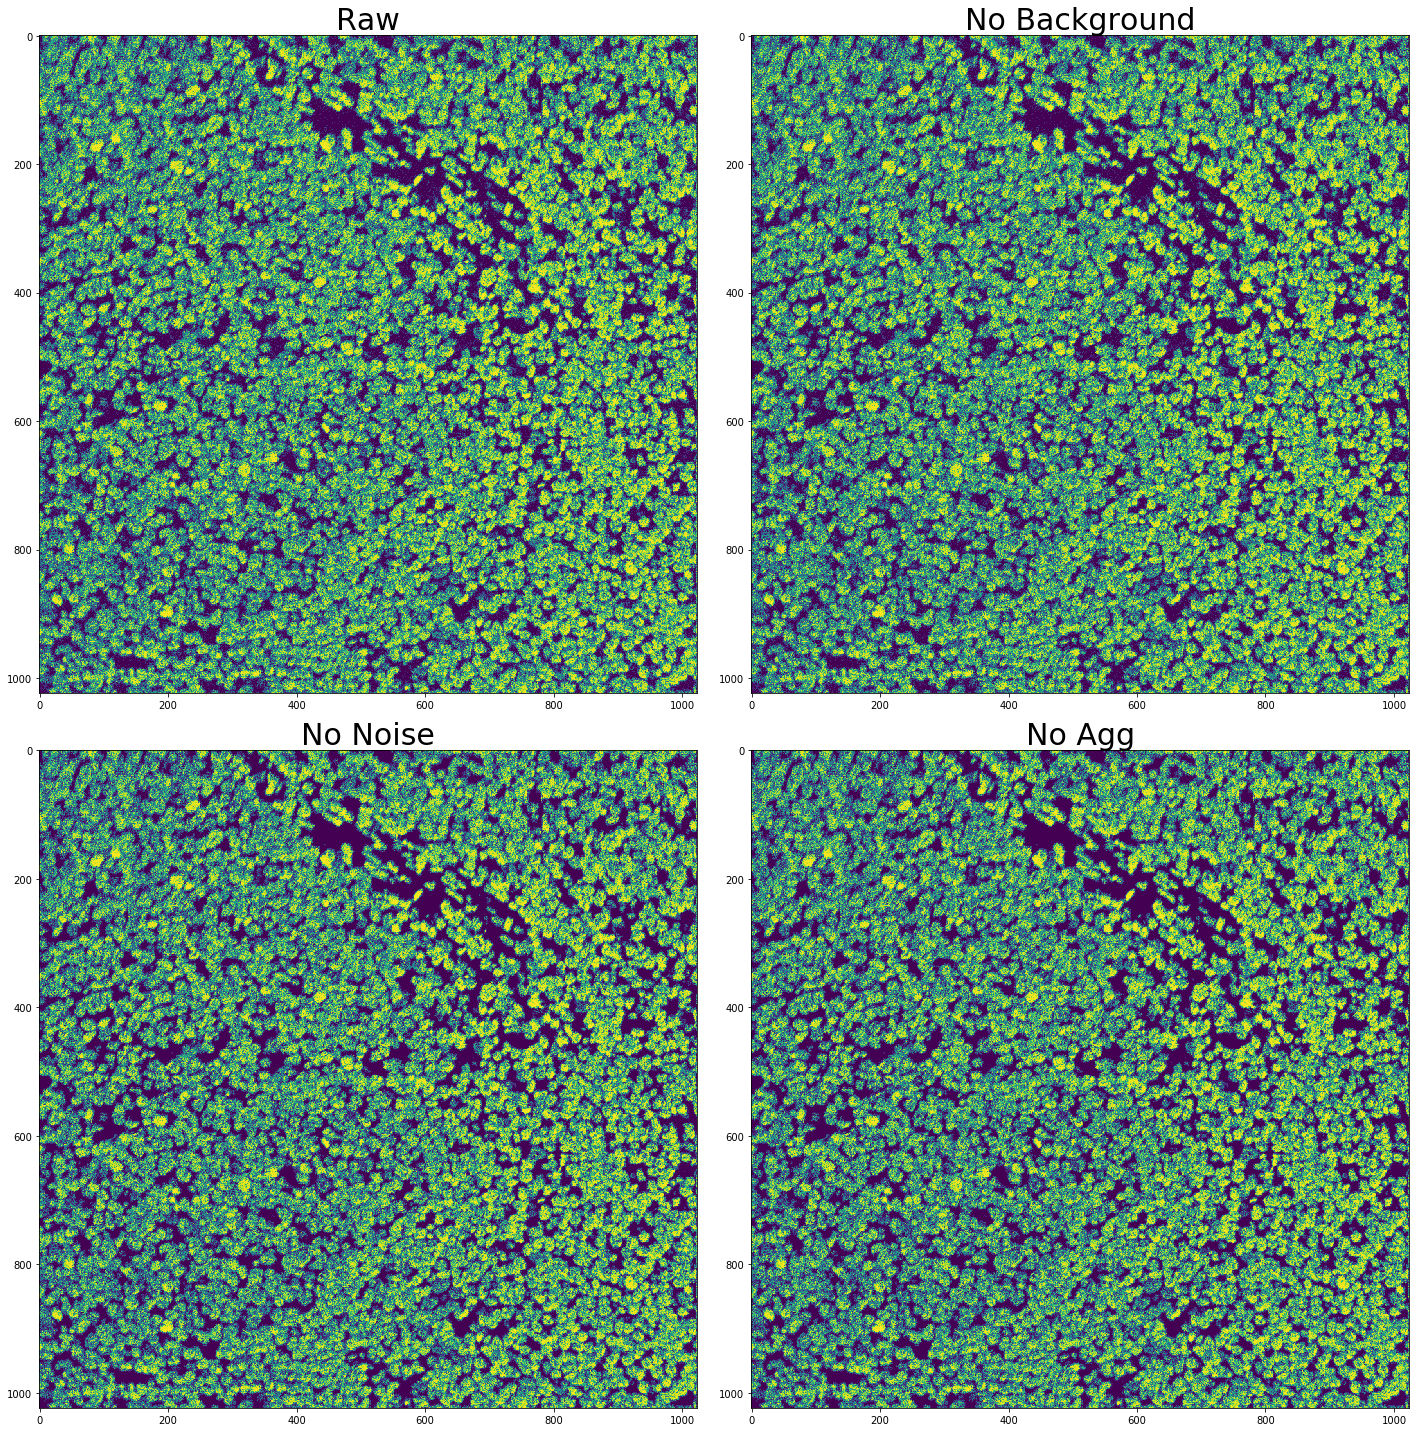

In [24]:
plotChannel = 'dsDNA'
plot_channel = list(massDS.Label.values).index(plotChannel)
plot_list = [countsAllSFiltCRSum[:,:,plot_channel],countsNoBg[:,:,plot_channel],countsNoNoise[:,:,plot_channel],dataNoAgg[:,:,plot_channel]]
plot_title = ['Raw','No Background','No Noise','No Agg']

plt.figure(figsize=(20,20))
for i in range(4):
	plt.subplot(2,2,i+1)
	plt.imshow(exposure.equalize_hist(plot_list[i]))
	plt.title(plot_title[i],fontsize=30)

plt.tight_layout()
#plt.savefig('dsDNA_output_sample')
plt.show()

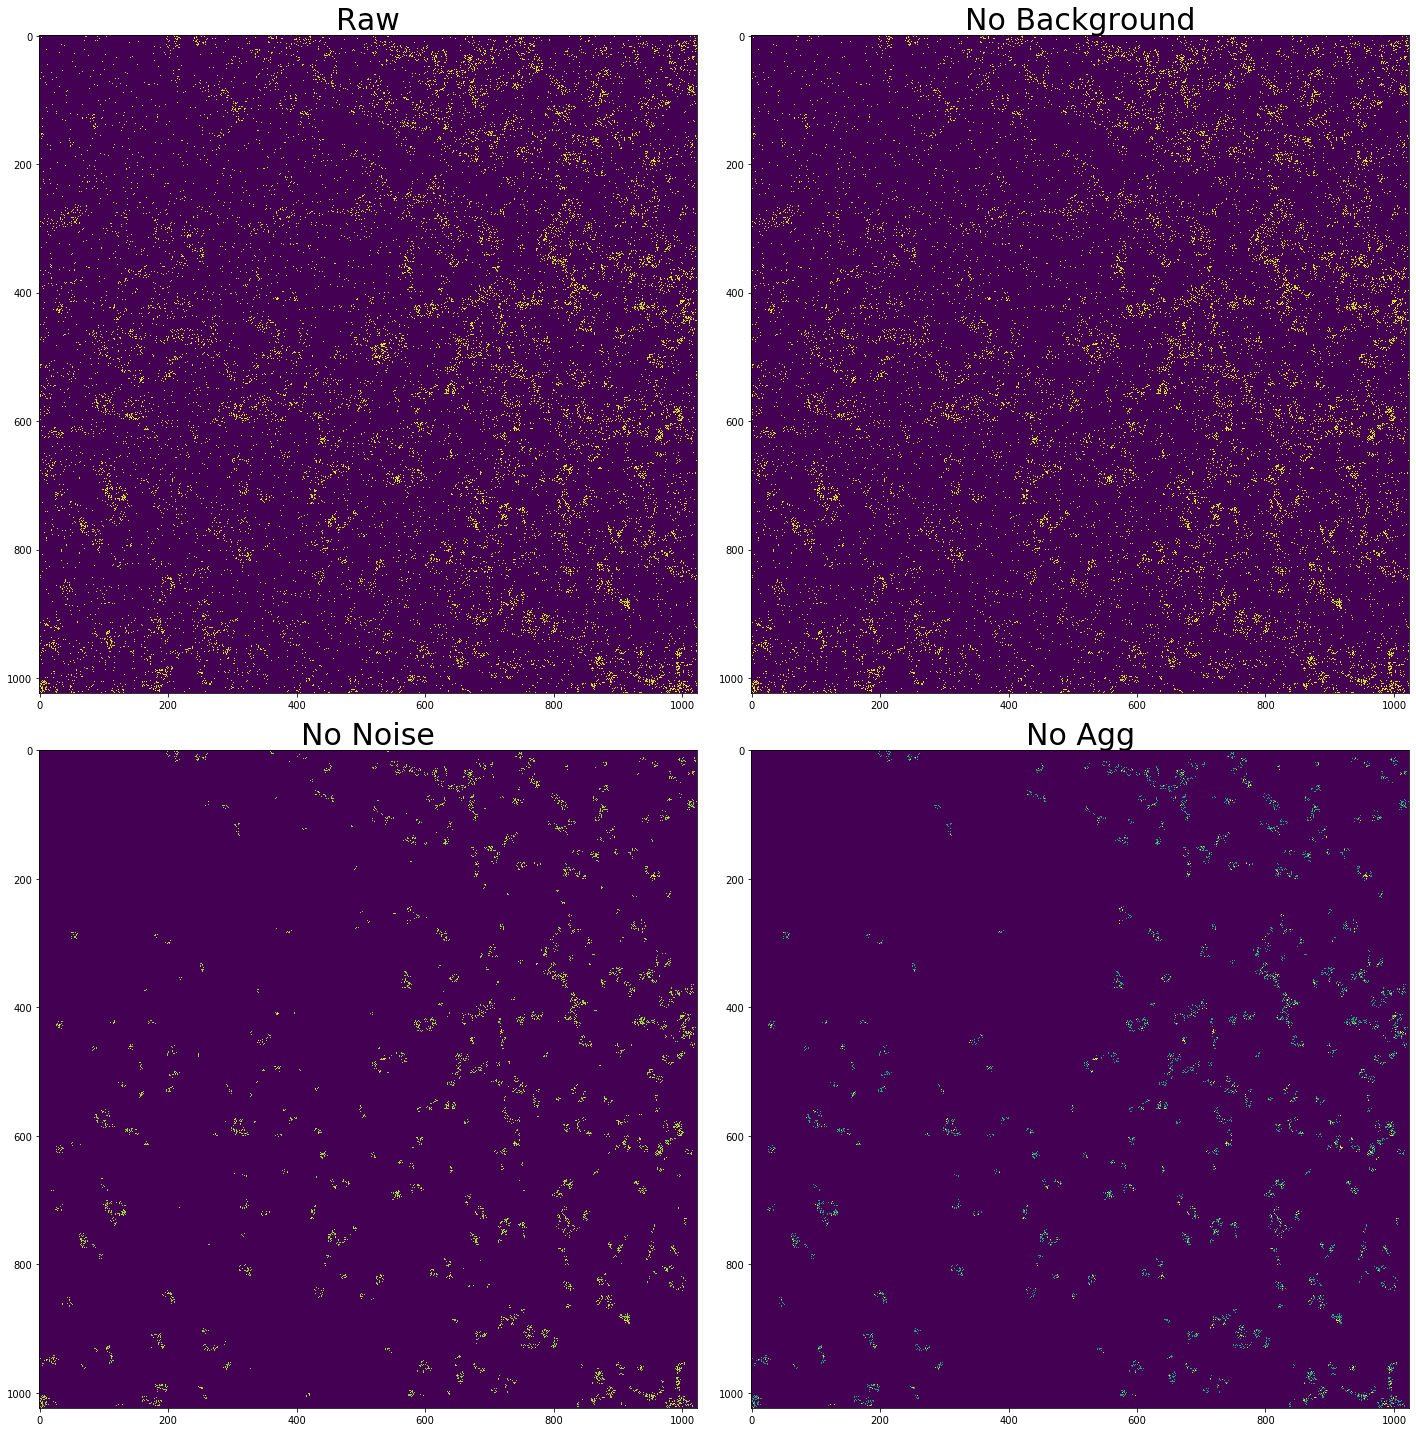

In [25]:
plotChannel = 'CD4'
plot_channel = list(massDS.Label.values).index(plotChannel)
plot_list = [countsAllSFiltCRSum[:,:,plot_channel],countsNoBg[:,:,plot_channel],countsNoNoise[:,:,plot_channel],dataNoAgg[:,:,plot_channel]]
plot_title = ['Raw','No Background','No Noise','No Agg']

plt.figure(figsize=(20,20))
for i in range(4):
	plt.subplot(2,2,i+1)
	plt.imshow(exposure.equalize_hist(plot_list[i]))
	plt.title(plot_title[i],fontsize=30)

plt.tight_layout()
#plt.savefig('MSK_HLA_DR_output_sample')
plt.show()

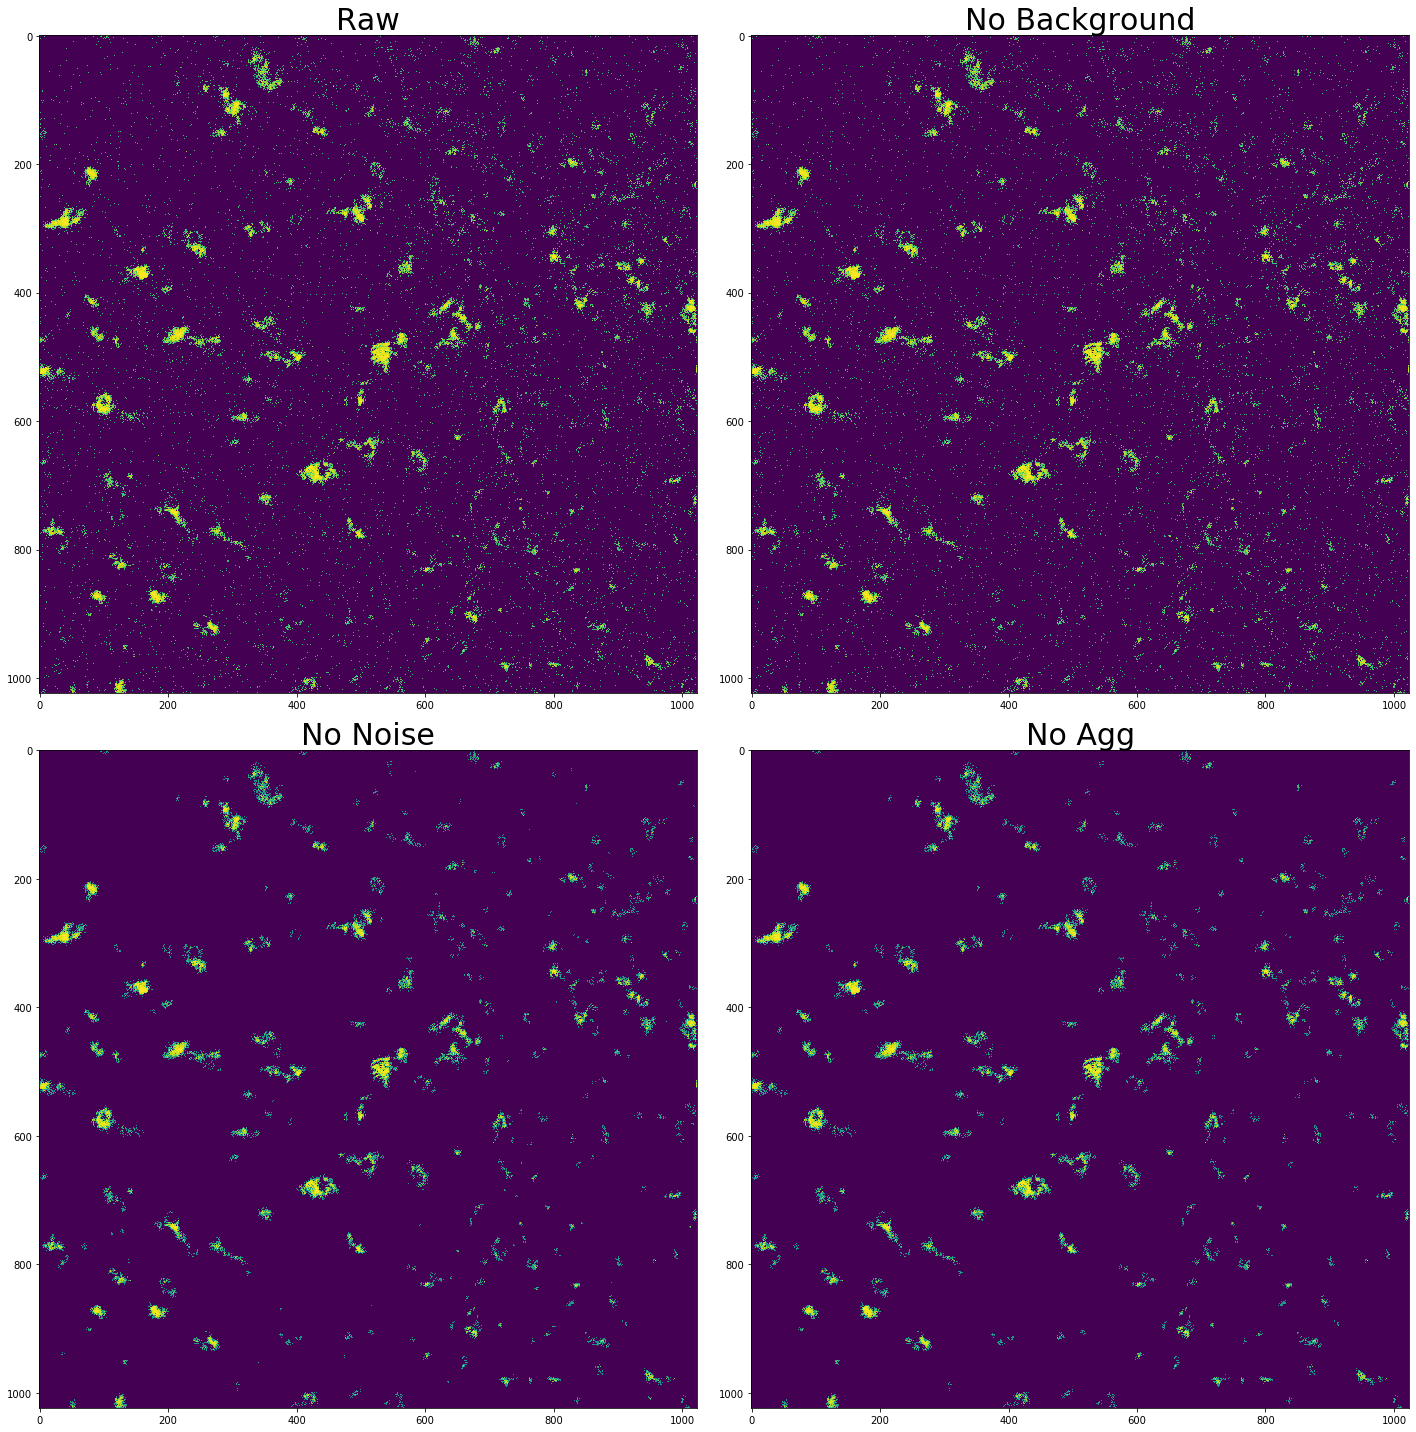

In [26]:
plotChannel = 'CD68'
plot_channel = list(massDS.Label.values).index(plotChannel)
plot_list = [countsAllSFiltCRSum[:,:,plot_channel],countsNoBg[:,:,plot_channel],countsNoNoise[:,:,plot_channel],dataNoAgg[:,:,plot_channel]]
plot_title = ['Raw','No Background','No Noise','No Agg']

plt.figure(figsize=(20,20))
for i in range(4):
	plt.subplot(2,2,i+1)
	plt.imshow(exposure.equalize_hist(plot_list[i]))
	plt.title(plot_title[i],fontsize=30)

plt.tight_layout()
# plt.savefig('MSK_CD68_output_sample')
plt.show()

## Acknowledgement 

This work is supported by Parker Institute for Cancer Immunotherapy